## Libraries

In [294]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import copy

## My functions

In [275]:
def my_draw_networkx_edge_labels(G,pos,edge_labels=None,label_pos=0.5,font_size=10,font_color="k",
    font_family="sans-serif",font_weight="normal",alpha=None,bbox=None,horizontalalignment="center",
    verticalalignment="center",ax=None,rotate=True,clip_on=True,rad=0):

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(x,y,label,size=font_size,color=font_color,family=font_family,
                weight=font_weight,alpha=alpha,horizontalalignment=horizontalalignment,
                verticalalignment=verticalalignment,rotation=trans_angle,transform=ax.transData,
                bbox=bbox,zorder=1,clip_on=clip_on)
        text_items[(n1, n2)] = t

    ax.tick_params(axis="both",which="both",bottom=False,left=False,labelbottom=False,labelleft=False)

    return text_items

In [318]:
class Q_table:
    def __init__(self,environment,actions=['L','R','U','D']):
        self.Q = {}
        self.actions = actions
        self.temp_env = environment
        for state in environment.states:
            for action in self.actions:
                self.Q[(state, action)] = 0
                
    def get(self,state,action):
        return self.Q[(state, action)]
    
    def set(self,state,action,data):
        self.Q[(state, action)] = data
        
    def best_move(self,environment,state):
        max_q = -1000000
        action_q = None
        for a in environment.valid_actions(state):
            q = self.get(state, a)
            if q > max_q:
                max_q = q
                action_q = a
        return action_q,max_q
    
    def display(self):
        # Print the final Q-table
        print("Q-table:")
        for state in self.temp_env.states:
            for action in self.actions:
                print("Q[{}, {}] = {}".format(state, action, Q[(state, action)]))
                
    def draw(self):
        # Create a directed graph
        G = nx.MultiDiGraph()
        # Add nodes to the graph
        states = self.temp_env.states
        
        # Add edges to the graph with rewards as weights
        for (state, action), reward in self.Q.items():
            next_state = self.temp_env.move(state,action)
            if next_state!=None:
                G.add_edge(state, next_state, weight=round(reward,1))

        # Draw the graph
        pos=nx.spring_layout(G,seed=5)
        def matrix_to_cartesian(matrix_coord, matrix_width, matrix_height):
            x = matrix_coord[1]
            y = matrix_height - matrix_coord[0] - 1
            return (x, y)

        colors = []
        c_map = {'W':'white','B':'#cc0000','F':'#b6d7a8','T':'#3e8520','A':'#6fa8dc'}
        for k,v in pos.items():
            pos[k]=matrix_to_cartesian((k[0],k[1]),*self.temp_env.size)
            colors.append(c_map[self.temp_env.get_state(k)])
        plt_size = 20 if self.temp_env.size[0]<6 else 30
        fig, ax = plt.subplots(figsize=(plt_size, plt_size))
        nx.draw_networkx_nodes(G, pos, ax=ax,node_size = 4000,
                              node_color = colors, edgecolors='k')
        nx.draw_networkx_labels(G, pos, ax=ax,font_size = 20)
        curved_edges = [edge for edge in G.edges() if (edge[1],edge[0]) in G.edges()]
        straight_edges = list(set(G.edges()) - set(curved_edges))
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges,node_size = 4000)
        arc_rad = 0.25
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges,node_size = 4000,
                               connectionstyle=f'arc3, rad = {arc_rad}',width = 4)

        edge_weights = nx.get_edge_attributes(G,'weight')
        curved_edge_labels = {edge: edge_weights[(edge[0],edge[1],0)] for edge in curved_edges}
        straight_edge_labels = {edge: edge_weights[(edge[0],edge[1],0)] for edge in straight_edges}
        my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,
                                     rotate=False,rad = arc_rad,font_size=10)
                
class Environment:
    def __init__(self,table,reward_map):
        self.table = table
        self.size = np.array(table).shape
        self.reward_map = reward_map
        
        self.states = []
        self.fill_states()
        
    def fill_states(self):
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                self.states.append((i, j))
                
    def get_state(self,state):
        return self.table[state[0]][state[1]]
    
    def set_state(self,state,data):
        self.table[state[0]][state[1]] = data
                
    def valid_actions(self,state):
        valid_actions = []
        if state[1] > 0 and self.table[state[0]][state[1]-1] != 'B':
            valid_actions.append('L')
        if state[1] < len(self.table[0])-1 and self.table[state[0]][state[1]+1] != 'B':
            valid_actions.append('R')
        if state[0] > 0 and self.table[state[0]-1][state[1]] != 'B':
            valid_actions.append('U')
        if state[0] < len(self.table)-1 and self.table[state[0]+1][state[1]] != 'B':
            valid_actions.append('D')
        return valid_actions
        
    def get_start_state(self):
        # Define the agent's starting position
        for state in self.states:
            if self.table[state[0]][state[1]] == 'A':
                return state
        print("Environment don't have any start state.")
        return None
    
    def move(self,state,action):
        # Take the action and get the new state and reward
        if action not in self.valid_actions(state):
            return None
        if action == 'L':
            return (state[0], state[1]-1)
        elif action == 'R':
            return (state[0], state[1]+1)
        elif action == 'U':
            return (state[0]-1, state[1])
        elif action == 'D':
            return (state[0]+1, state[1])
        
    def any_flag_target(self):
        a = np.array(self.table).flatten()
        return ('T' in a) or ('F' in a)
    def any_flag(self):
        a = np.array(self.table).flatten()
        return ('F' in a)
        
    # Define the reward table
    def get_reward(self,state):
        return self.reward_map[self.get_state(state)]

    def copy(self):
        return copy.deepcopy(self)
        
    

In [361]:
class Q_learning:
    def __init__(self, alpha, gamma, epsilon,episode_count):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episode_count = episode_count
        self.Q = None

    def fit(self, environment):
        # Start the Q-Learning algorithm
        Q = Q_table(environment)
        epsilon_decrease = self.epsilon/self.episode_count
        epsilon = self.epsilon
        for episode in range(self.episode_count):
            #if episode%100==0:
            #    print(f'Episode: {episode}/{self.episode_count}')
            state = environment.get_start_state()
            cur_env = environment.copy()
            target_seen = False
            episode_len = 0
            env_size = cur_env.size[0]*cur_env.size[1]
            epsilon = epsilon - epsilon_decrease
            while (episode_len<env_size or not target_seen) and episode_len<1.5*env_size:
                episode_len+=1
                # Choose an action
                valid_actions = cur_env.valid_actions(state)
                if np.random.uniform(0, 1) < epsilon:
                    action = np.random.choice(valid_actions)
                else:
                    action,_ = Q.best_move(cur_env,state)

                # Take the action and get the new state and reward
                new_state = cur_env.move(state,action)
                reward = cur_env.get_reward(new_state)

                # Update the Q-table
                _,max_q = Q.best_move(cur_env,new_state)
                new_q = (1-self.alpha)*Q.get(state,action)+self.alpha*(reward+self.gamma*max_q)
                Q.set(state, action, new_q)
                
                # Update the state & environment(Delete flag)
                state = new_state
                if cur_env.get_state(state)=='F':
                    cur_env.set_state(state,'W') 
                if cur_env.get_state(state)=='T':
                    cur_env.set_state(state,'W') 
                    target_seen = True
                if not cur_env.any_flag_target():
                    break
        self.Q = Q
        return Q

    # Find the path from the Q-table
    def get_path(self,environment):
        max_reward = -1000000
        path_best = None
        for i in range(1000):
            try:
                find_result,reward,path = self.get_path_once(environment)
            except:
                continue
            if find_result and reward>max_reward:
                max_reward=reward
                path_best = path
        if path_best is None:
            return None
        return self.delete_loop(environment,path_best)
    def get_path_once(self,environment_in):
        def choose_next_state(environment,state):
            valid_actions = environment.valid_actions(state)
            action_point = []
            for action_q in valid_actions:
                cur_point = self.Q.get(state, action_q)
                new_state = environment.move(state,action_q)

                valid_next_action = environment.valid_actions(new_state)
                future_point = max([self.Q.get(new_state, second_action) for second_action in valid_next_action])

                point = np.mean([cur_point,future_point])
                action_point.append(point)
            action_point = np.array(action_point)
            if min(action_point)<0:
                action_point = action_point+min(action_point)+10
            action_point = action_point/sum(action_point)
            return np.random.choice(valid_actions,p=action_point)
        
        environment = environment_in.copy()
        states = environment.states
        state = environment.get_start_state()
        path = []
        reward = 0
        find_result = False
        while not find_result:
            action_q = choose_next_state(environment,state)
            path.append((state, action_q))
            state = environment.move(state,action_q)

            if environment.get_state(state)=='T':
                if not environment.any_flag():
                    find_result = True
            else:
                reward+=environment.get_reward(state)

            if environment.get_state(state)=='F':
                environment.set_state(state,'W')
            if reward<environment.reward_map['W']*environment.size[0]*environment.size[1]:
                break

        return find_result,reward,path
    def delete_loop(self,environment,path_in):
        def find_similar_state(i):
            for j in range(1,len(path)-i):
                state = path[i+j][0]
                if environment.get_state(state)=='F' and state not in seen_flags:
                    return None
                if path[i+j][0]==path[i][0]:
                    return j
            return None
        seen_flags = set()
        path = path_in.copy()
        i=0
        while i<len(path):
            state = path[i][0]
            if environment.get_state(state)=='F':
                seen_flags.add(state)

            j = find_similar_state(i)
            if j is not None:
                path = path[:i]+path[i+j:]
            else:
                i+=1
        return path

Episode: 0/1000
Episode: 100/1000
Episode: 200/1000
Episode: 300/1000
Episode: 400/1000
Episode: 500/1000
Episode: 600/1000
Episode: 700/1000
Episode: 800/1000
Episode: 900/1000


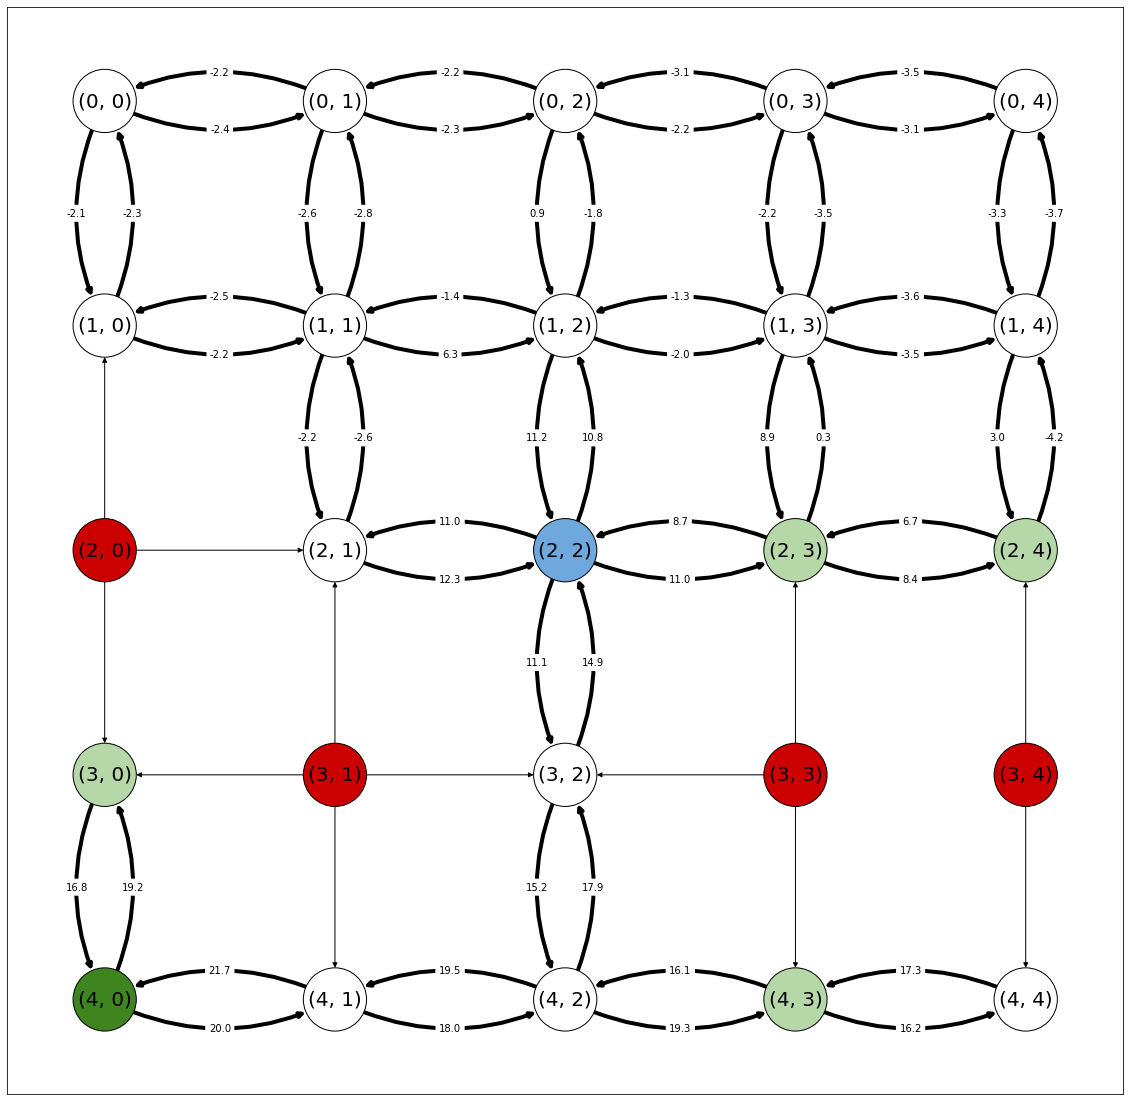

In [349]:
table = [
    ['W', 'W', 'W', 'W', 'W'],
    ['W', 'W', 'W', 'W', 'W'],
    ['B', 'W', 'A', 'F', 'F'],
    ['F', 'B', 'W', 'B', 'B'],
    ['T', 'W', 'W', 'F', 'W']]
reward = {'B':-100,'F':30,'T':100,'W':-3,'A':-3}

environment = Environment(table,reward)
model = Q_learning(alpha=0.1, gamma=0.9, epsilon=0.3,episode_count=1000)
Q = model.fit(environment)
Q.draw()

In [350]:
model.get_path(environment)

[((2, 2), 'R'),
 ((2, 3), 'R'),
 ((2, 4), 'L'),
 ((2, 3), 'L'),
 ((2, 2), 'D'),
 ((3, 2), 'D'),
 ((4, 2), 'R'),
 ((4, 3), 'L'),
 ((4, 2), 'L'),
 ((4, 1), 'L'),
 ((4, 0), 'U'),
 ((3, 0), 'D')]

Episode: 0/2000
Episode: 100/2000
Episode: 200/2000
Episode: 300/2000
Episode: 400/2000
Episode: 500/2000
Episode: 600/2000
Episode: 700/2000
Episode: 800/2000
Episode: 900/2000
Episode: 1000/2000
Episode: 1100/2000
Episode: 1200/2000
Episode: 1300/2000
Episode: 1400/2000
Episode: 1500/2000
Episode: 1600/2000
Episode: 1700/2000
Episode: 1800/2000
Episode: 1900/2000


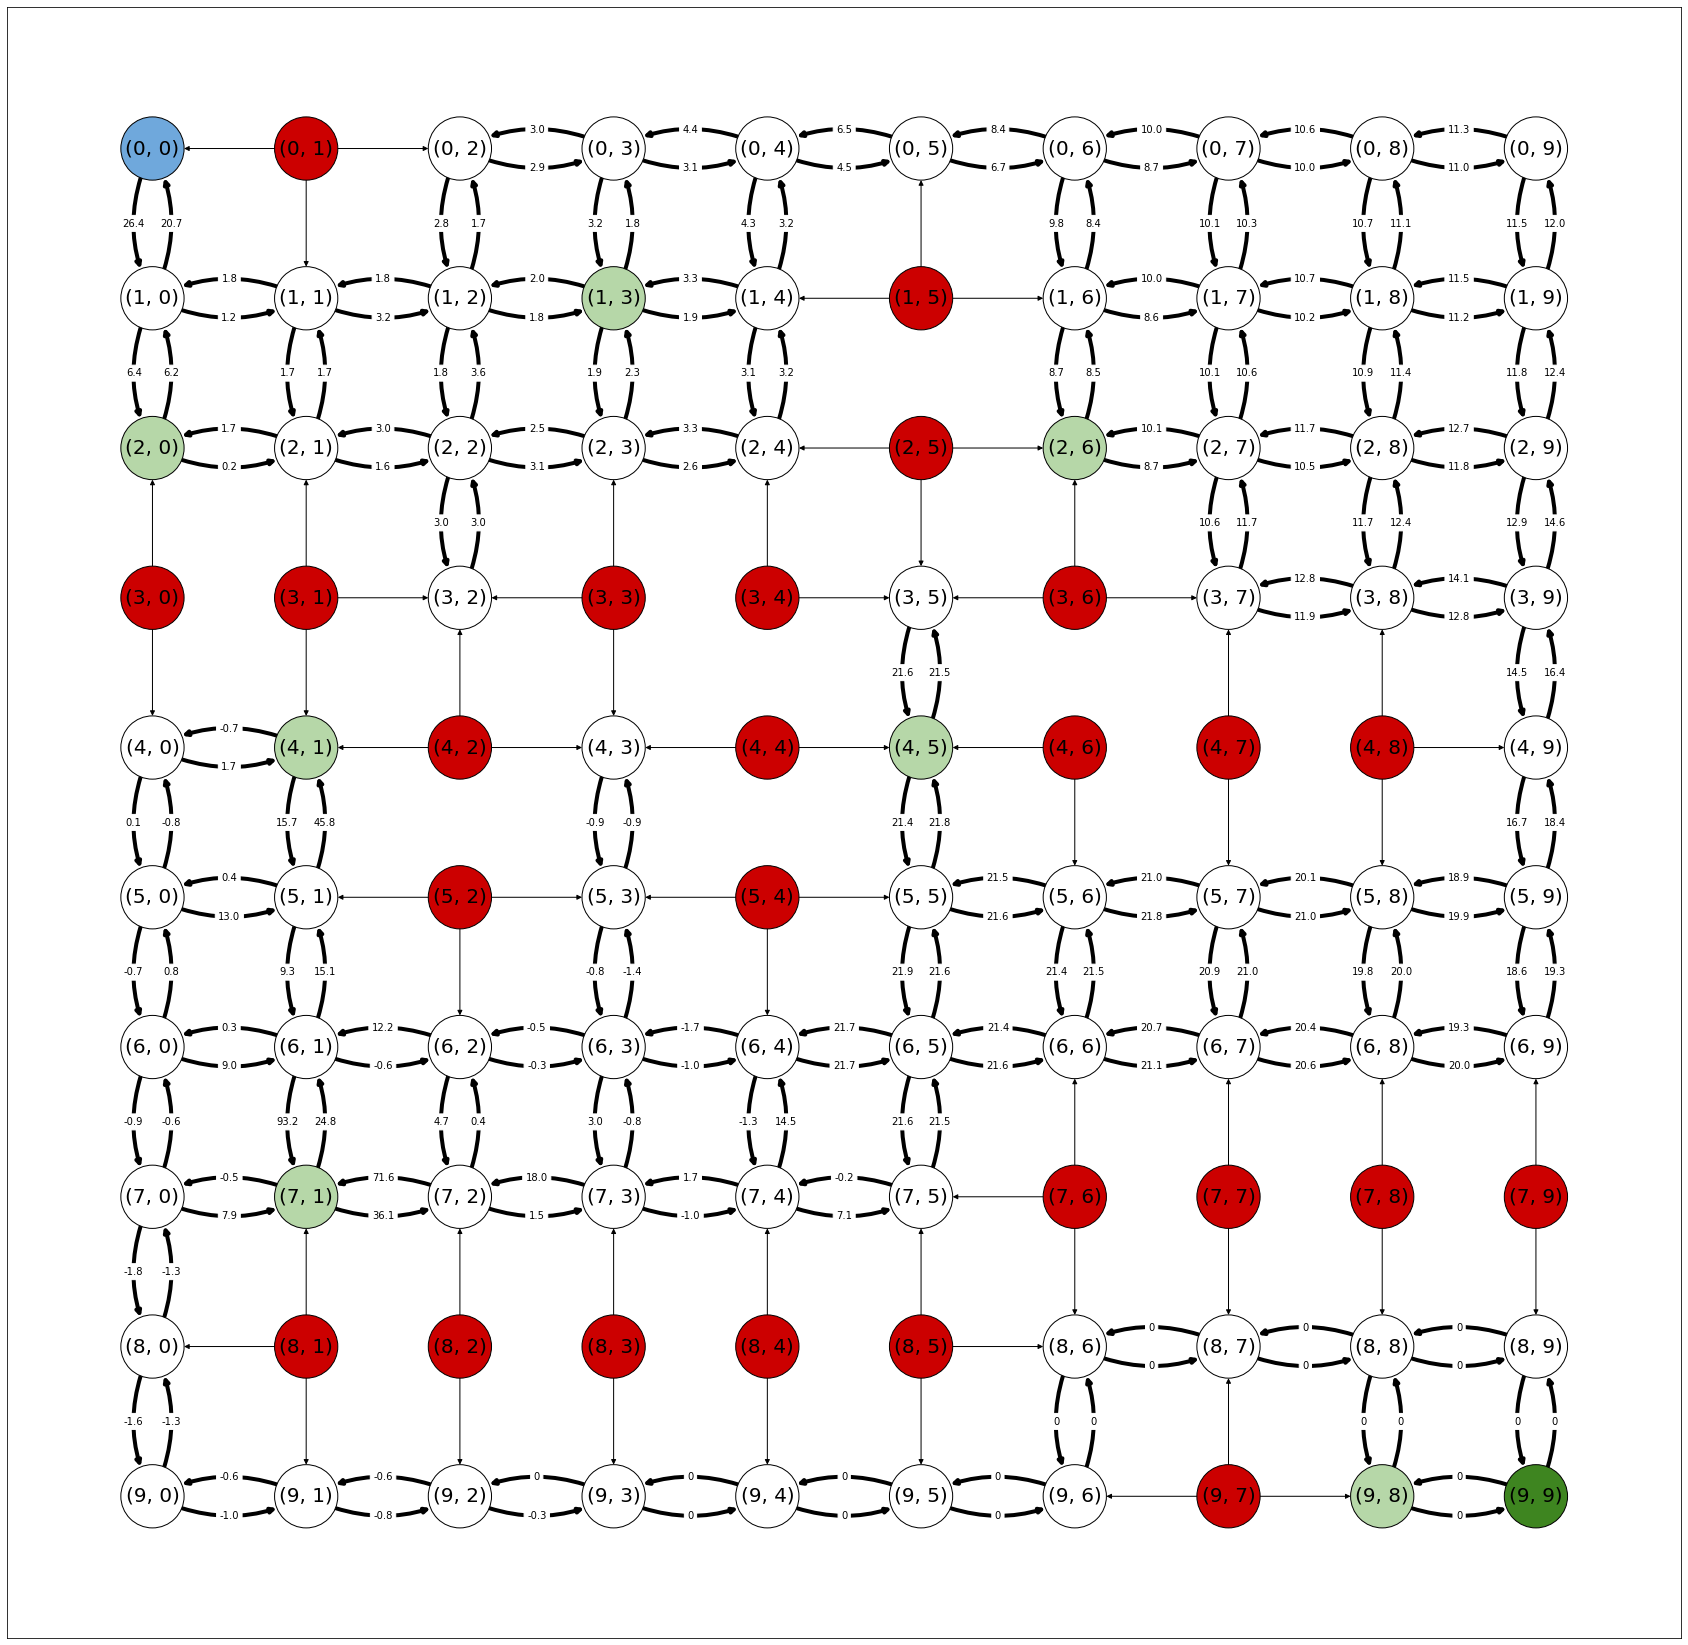

In [353]:
# Define the environment
table = [
       ['A', 'B', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'F', 'W', 'B', 'W', 'W', 'W', 'W'],
       ['F', 'W', 'W', 'W', 'W', 'B', 'F', 'W', 'W', 'W'],
       ['B', 'B', 'W', 'B', 'B', 'W', 'B', 'W', 'W', 'W'],
       ['W', 'F', 'B', 'W', 'B', 'F', 'B', 'B', 'B', 'W'],
       ['W', 'W', 'B', 'W', 'B', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'F', 'W', 'W', 'W', 'W', 'B', 'B', 'B', 'B'],
       ['W', 'B', 'B', 'B', 'B', 'B', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'F', 'T']]

reward = {'B':-100,'F':300,'T':1000,'W':-3,'A':-3}

environment = Environment(table,reward)
model = Q_learning(alpha=0.1, gamma=0.9, epsilon=1,episode_count=2000)
Q = model.fit(environment)
Q.draw()

gamma:0.25,alpha:0.1


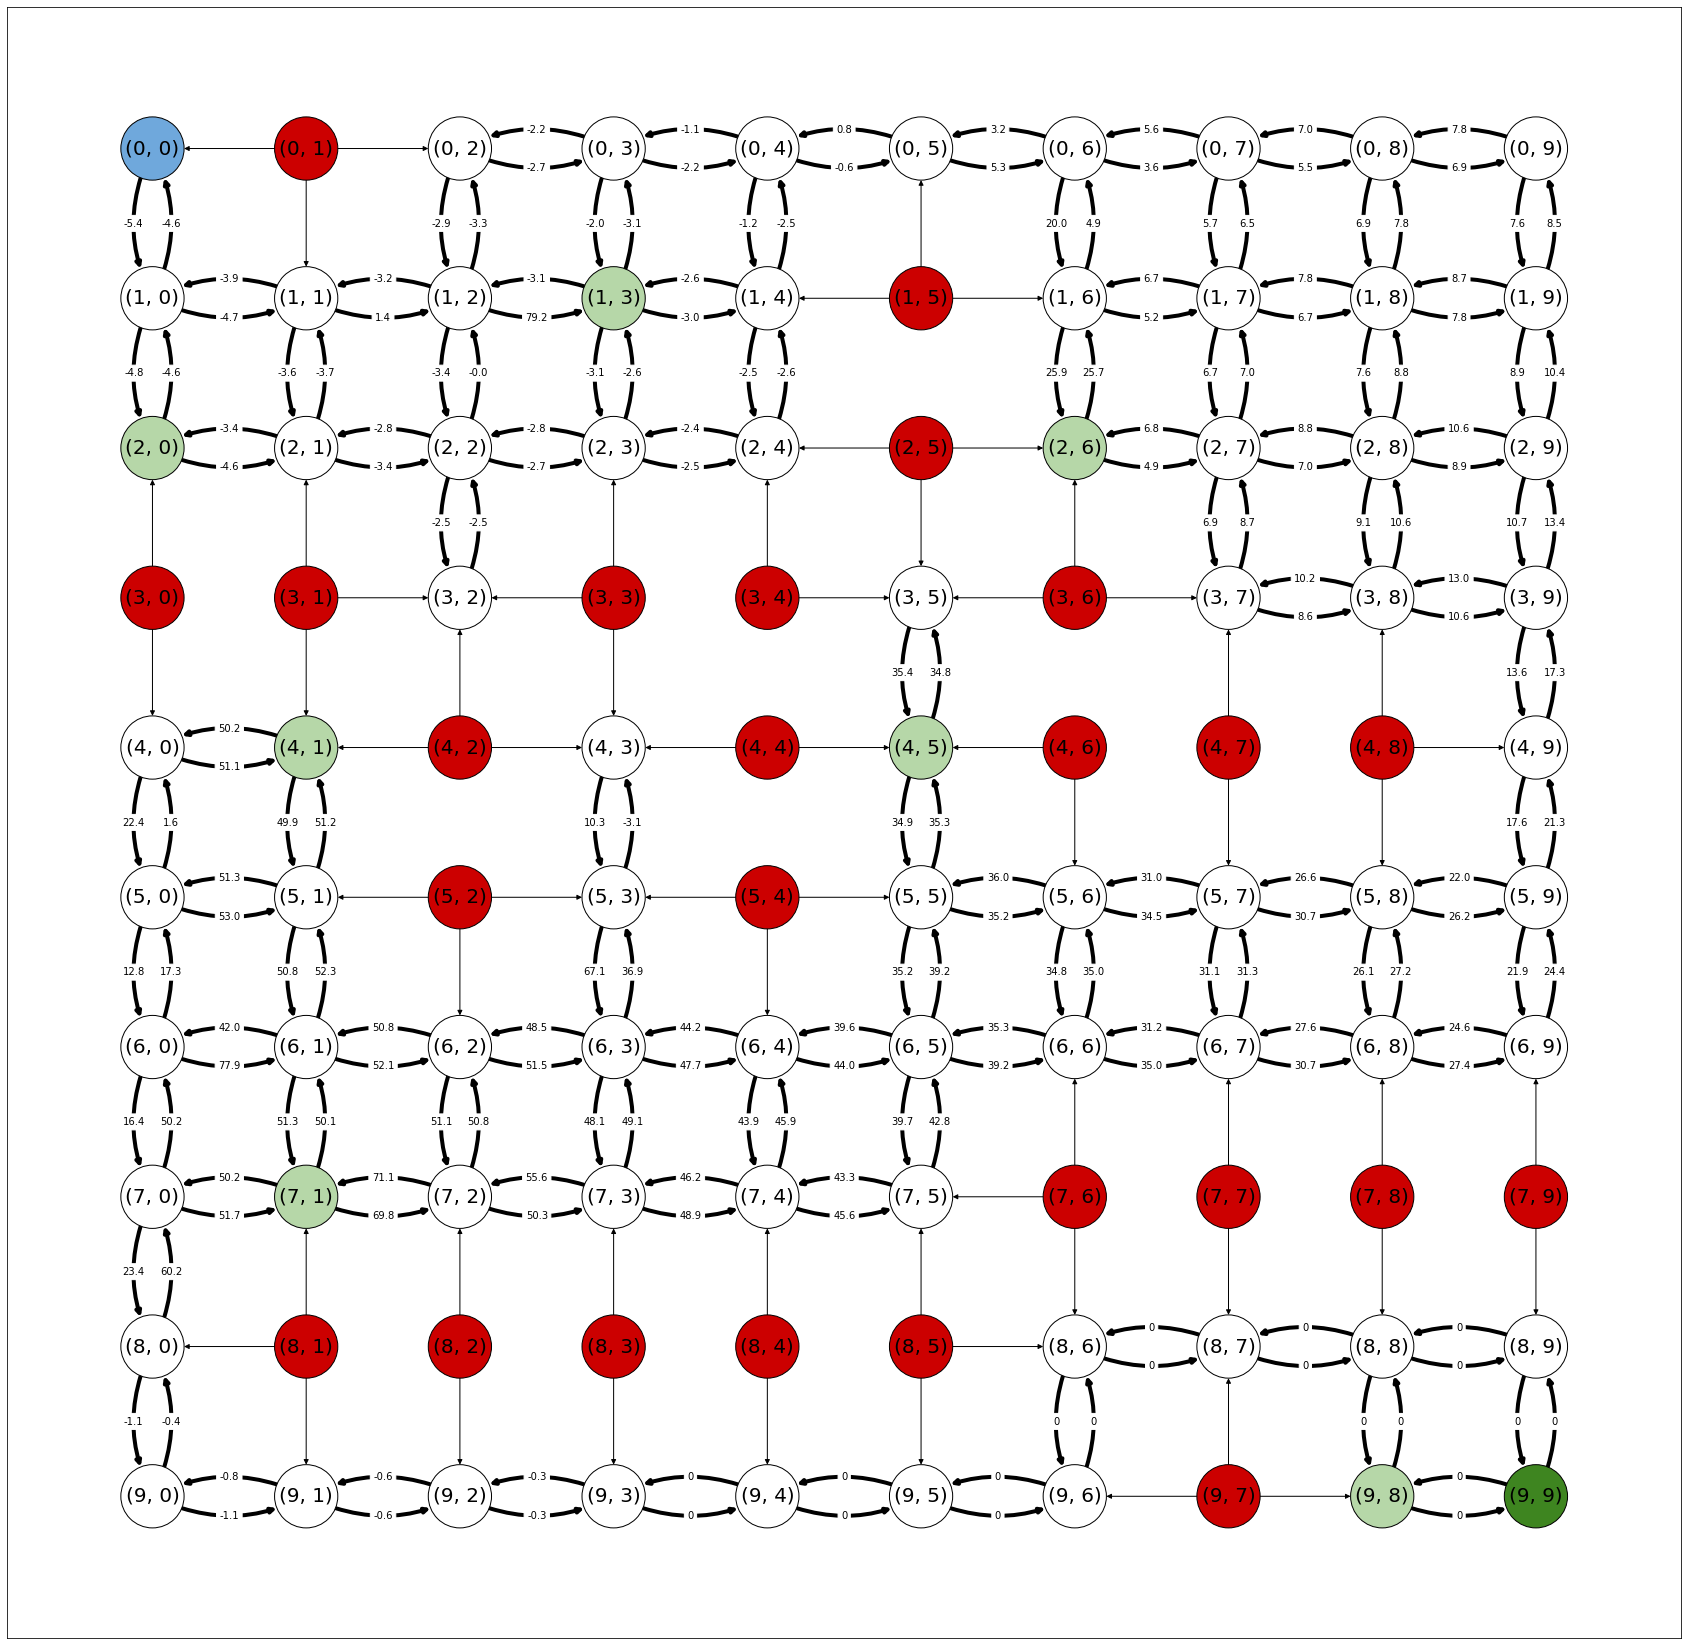

gamma:0.25,alpha:0.5


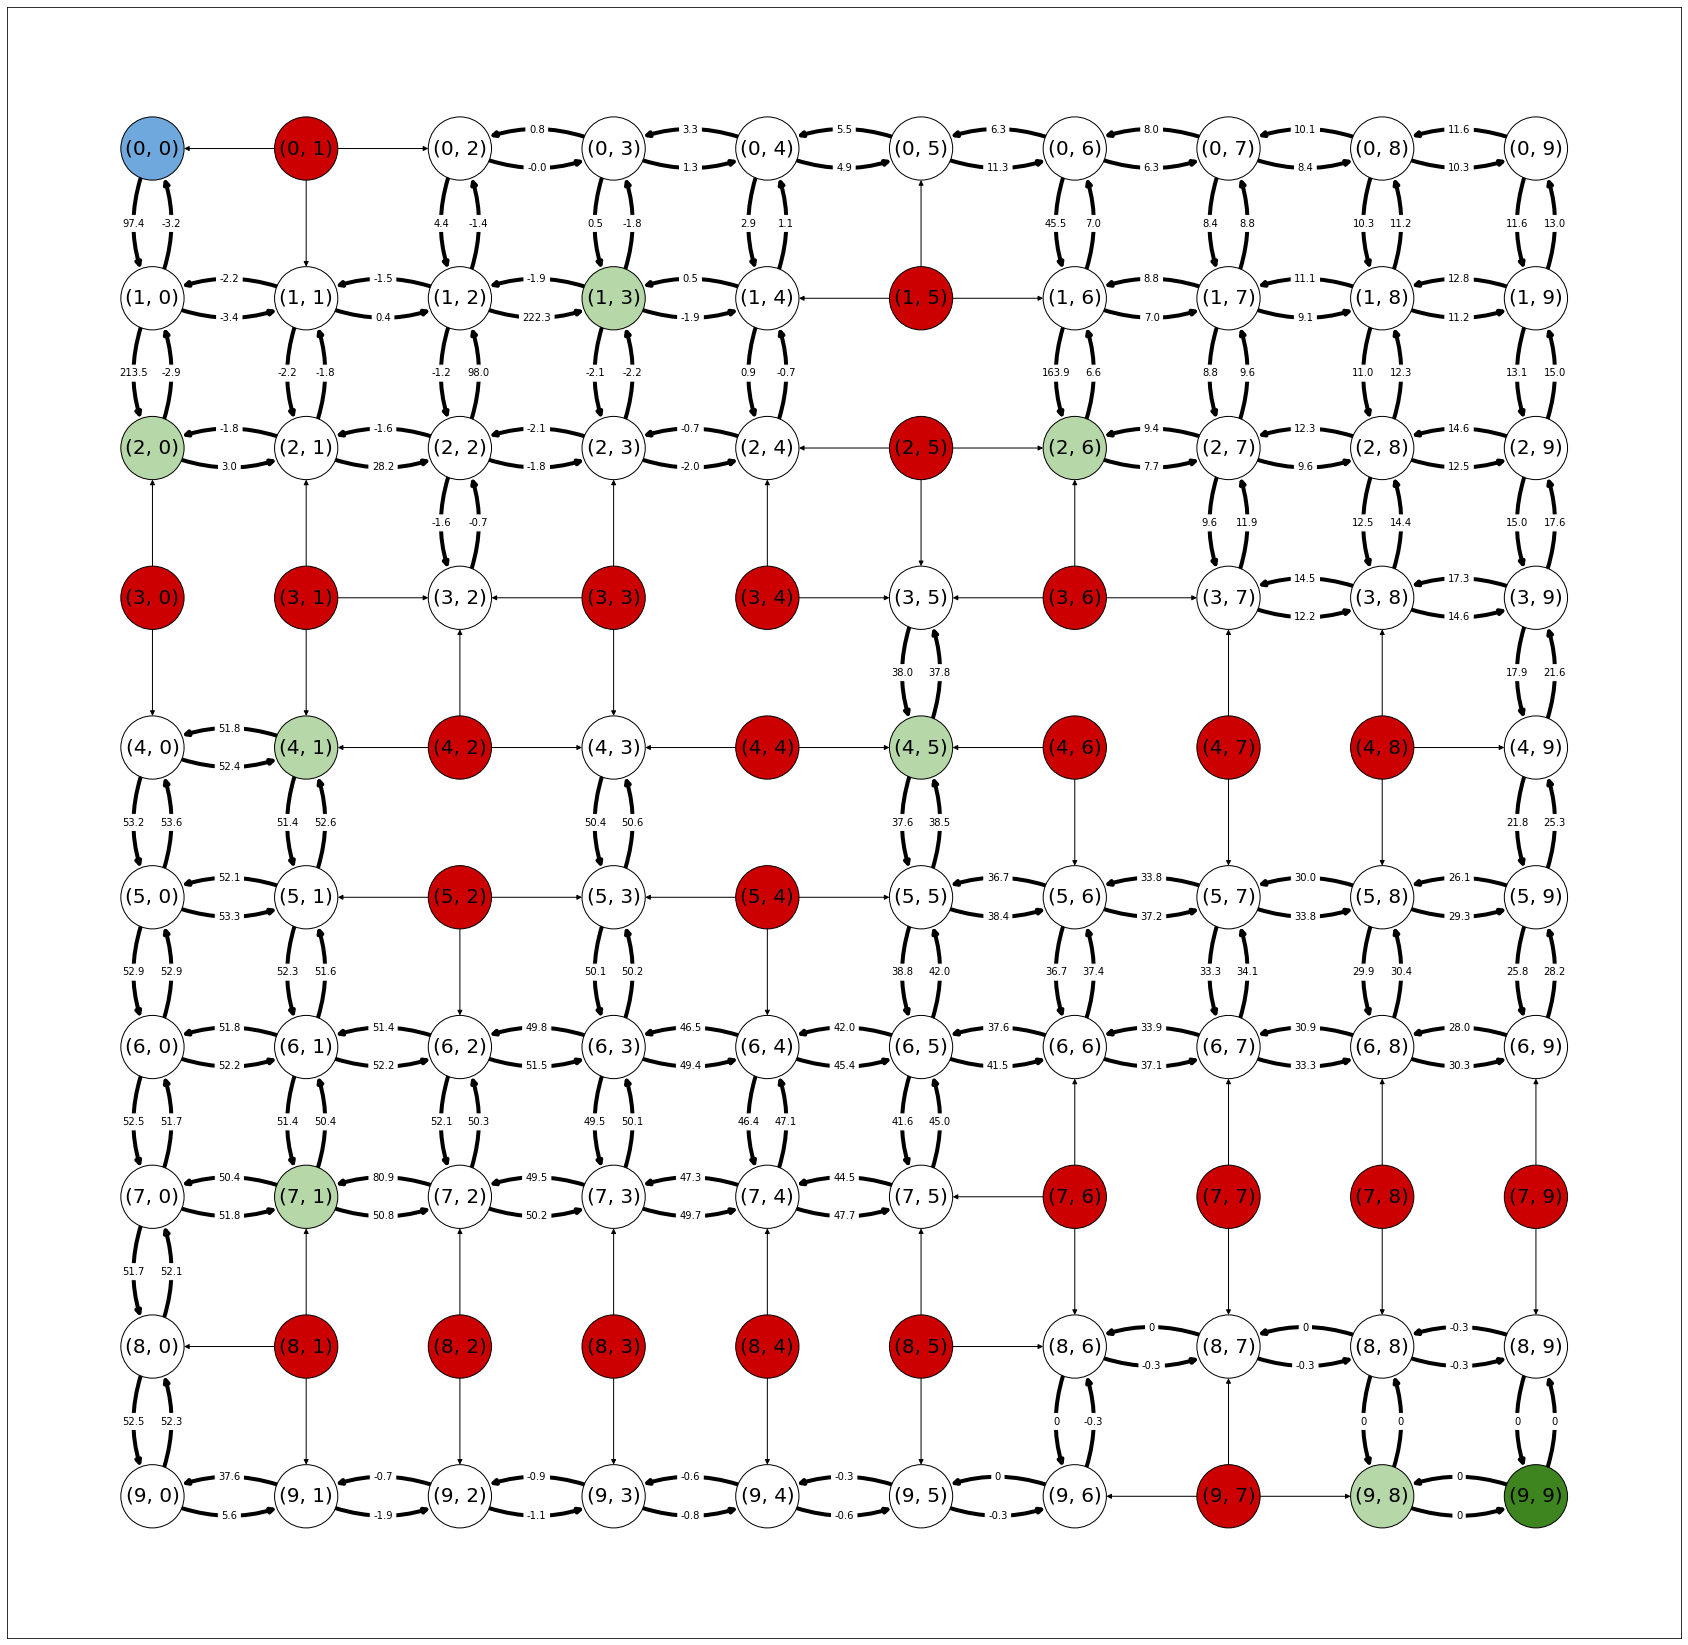

gamma:0.25,alpha:1


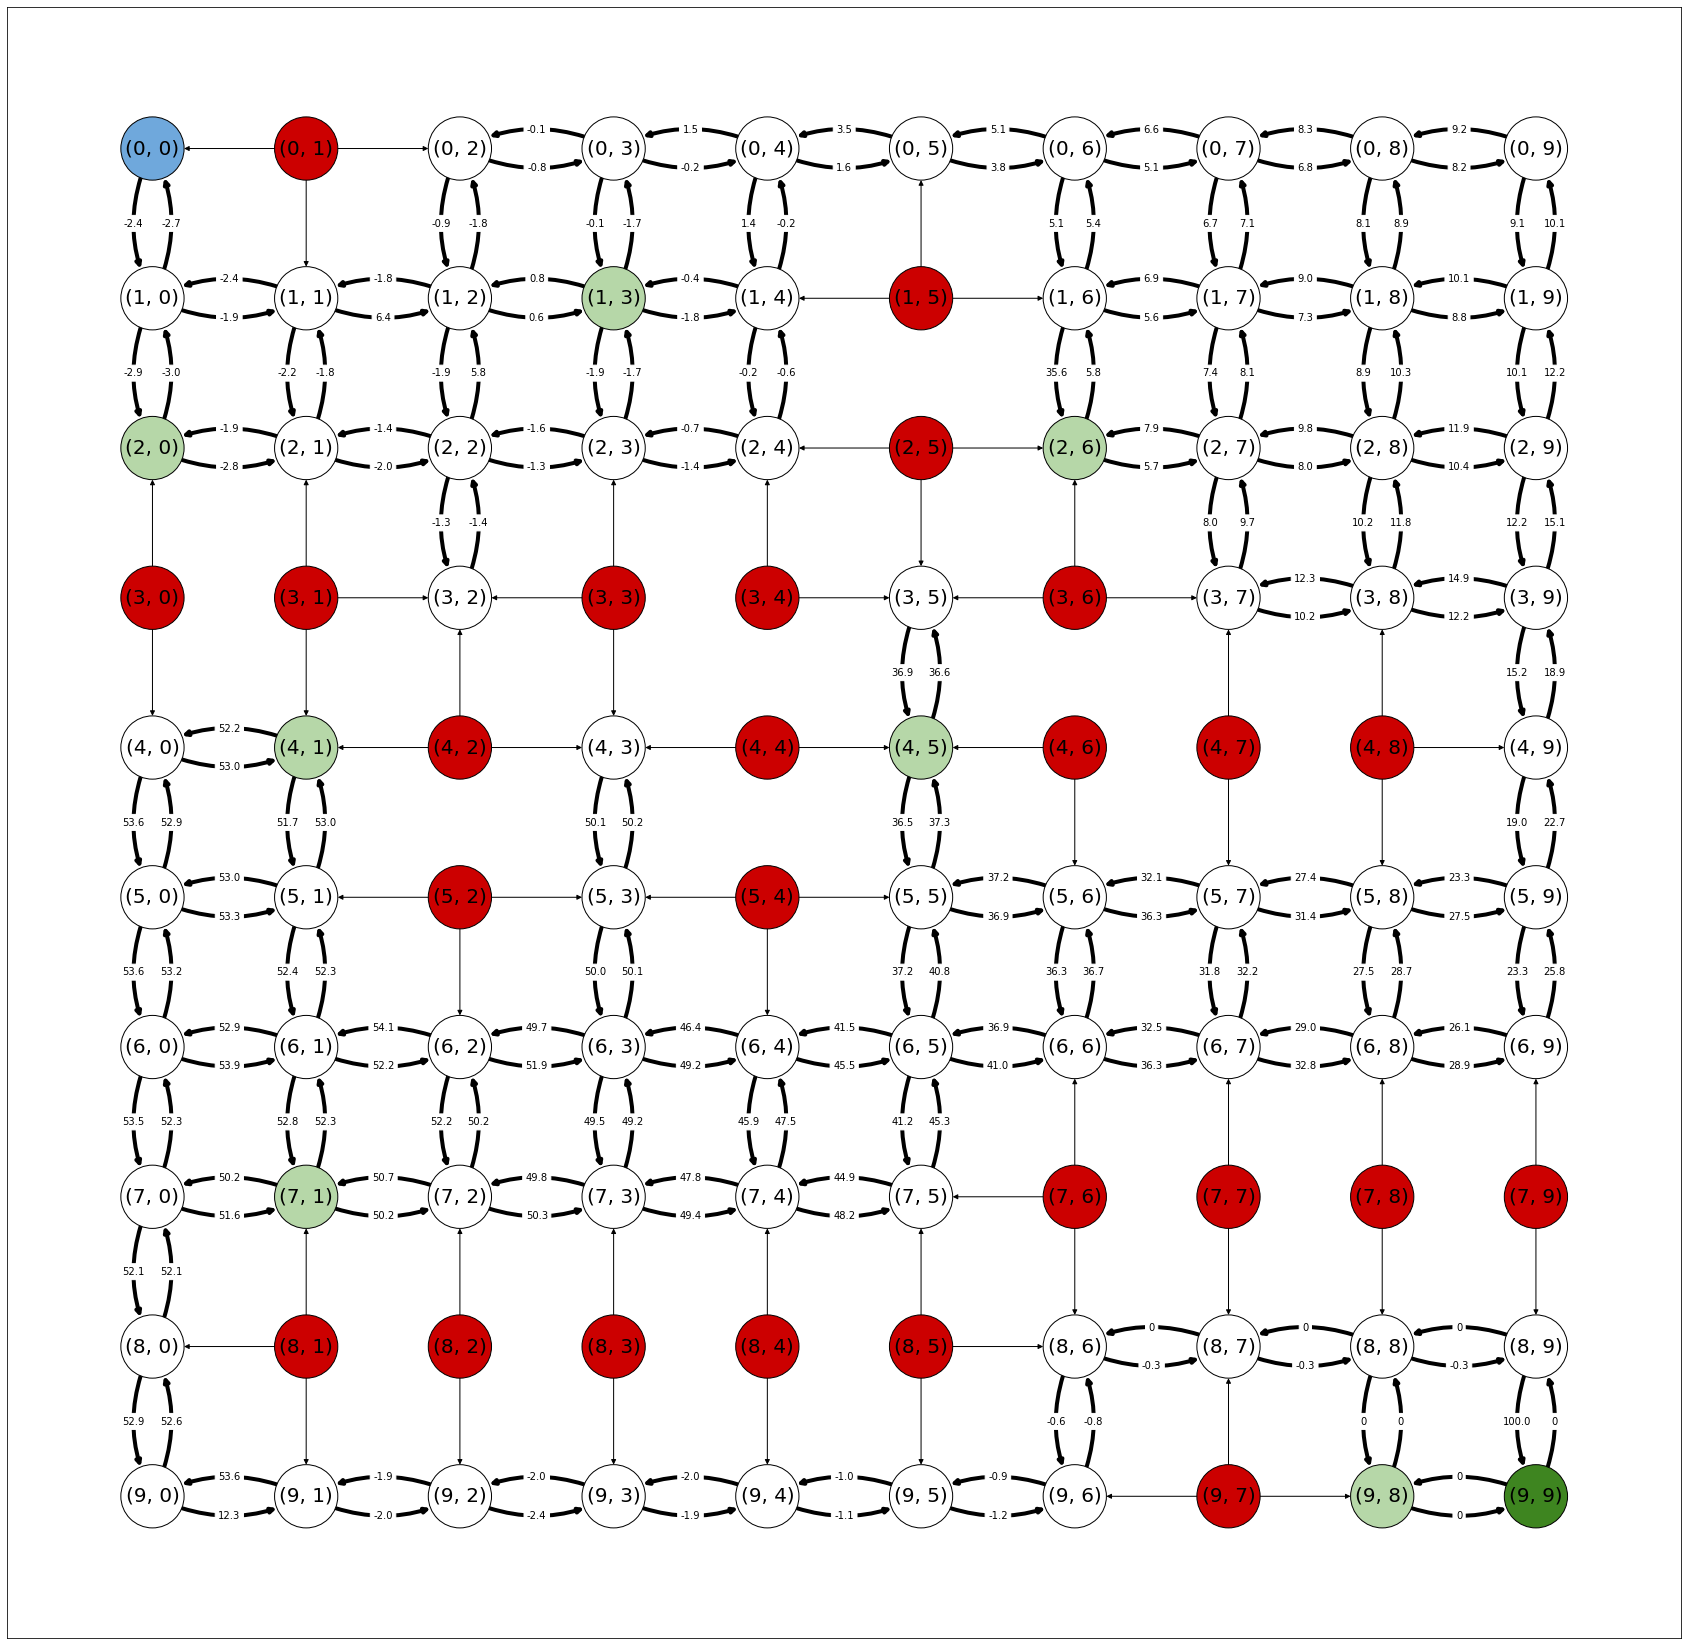

gamma:0.5,alpha:0.1


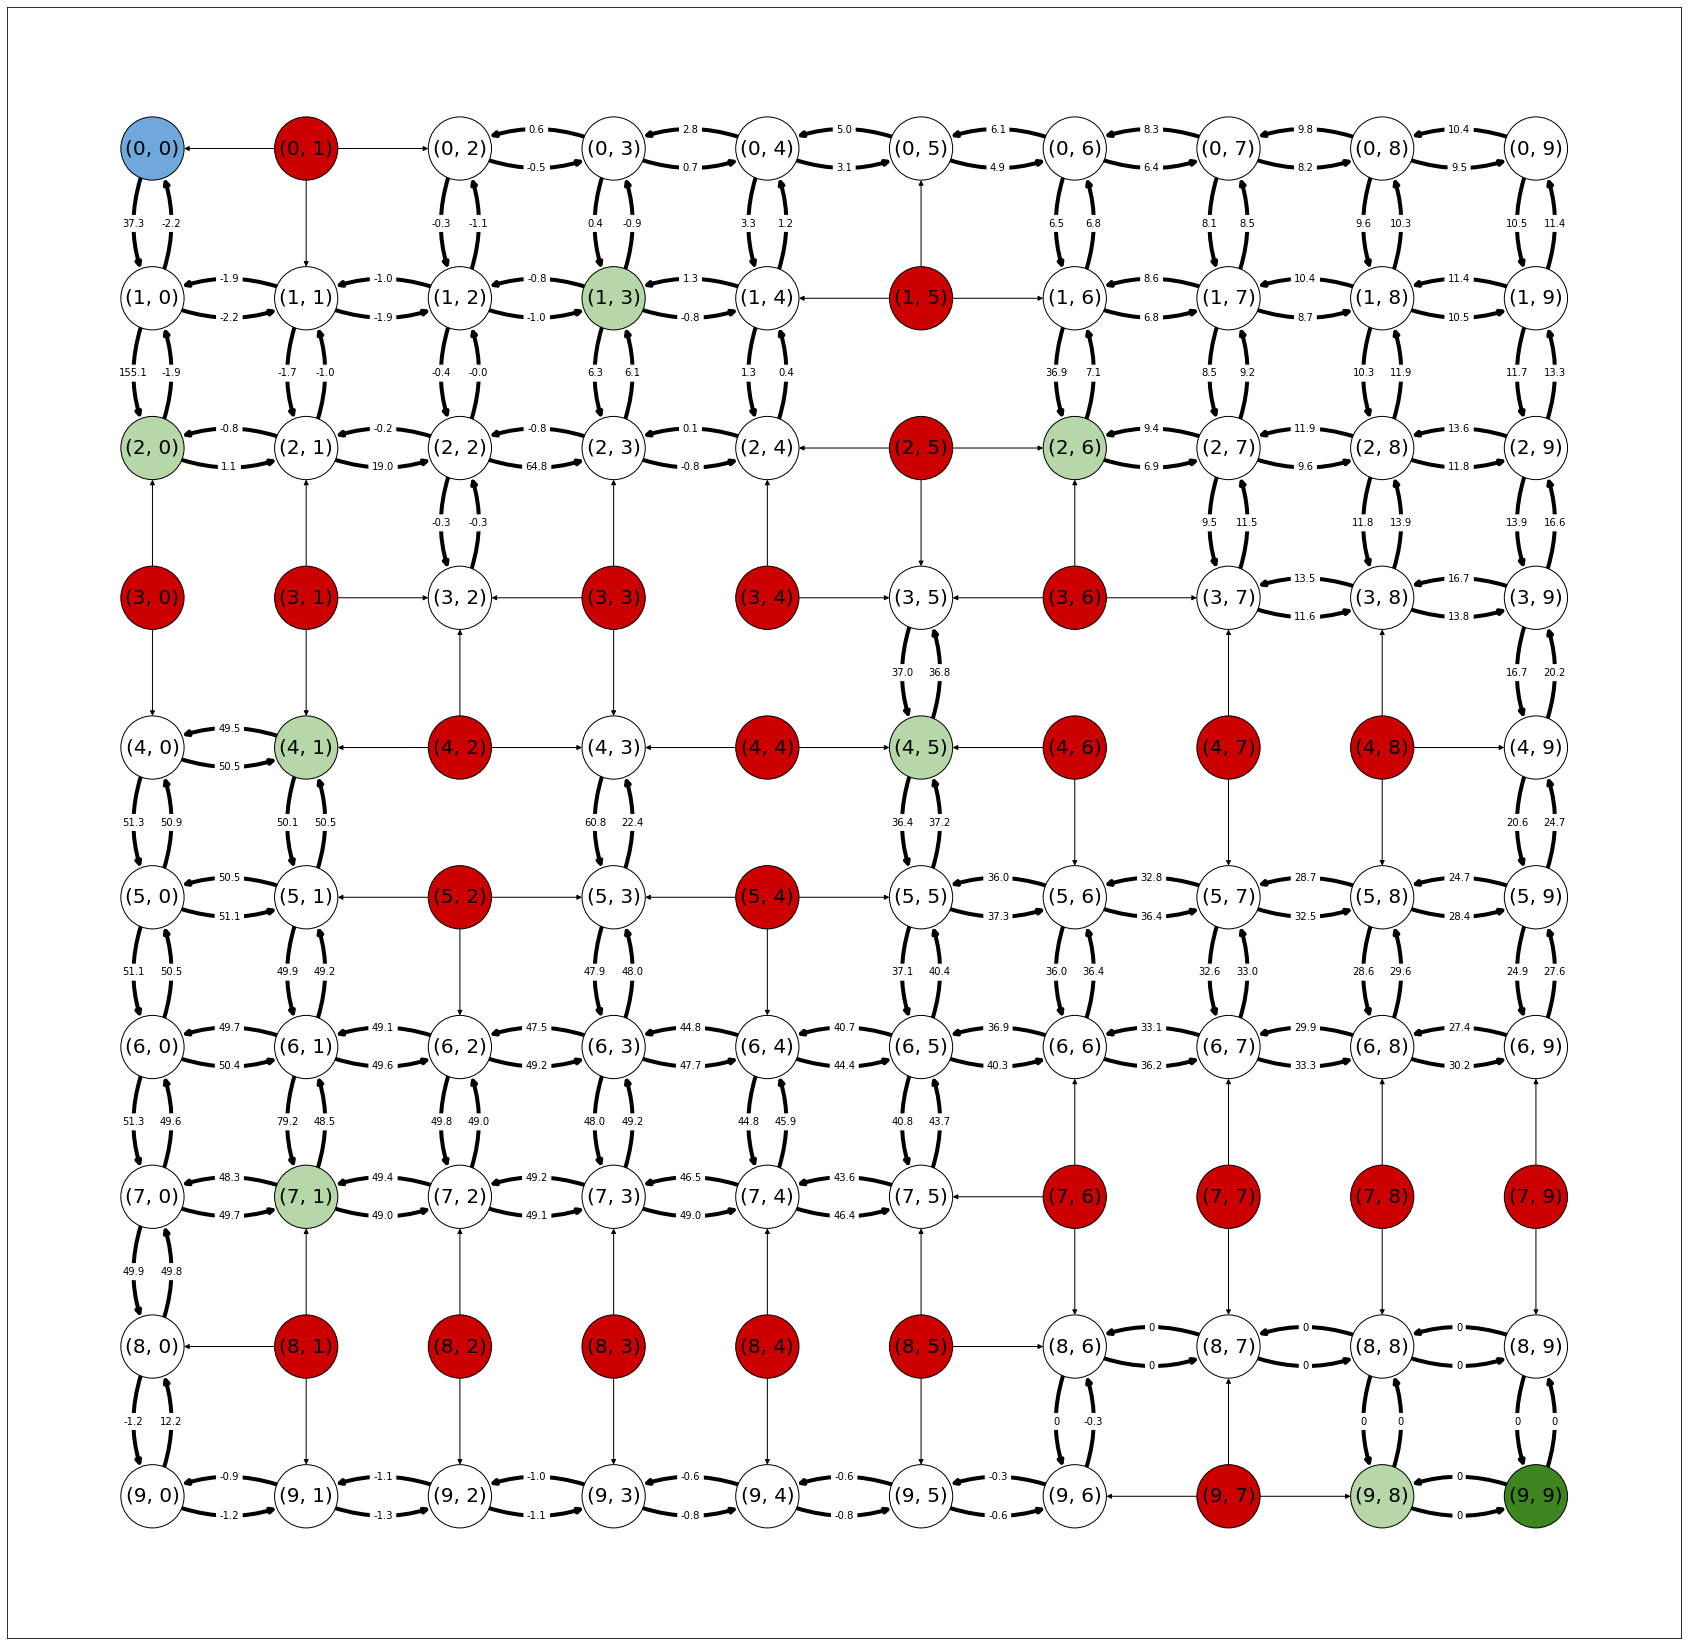

gamma:0.5,alpha:0.5


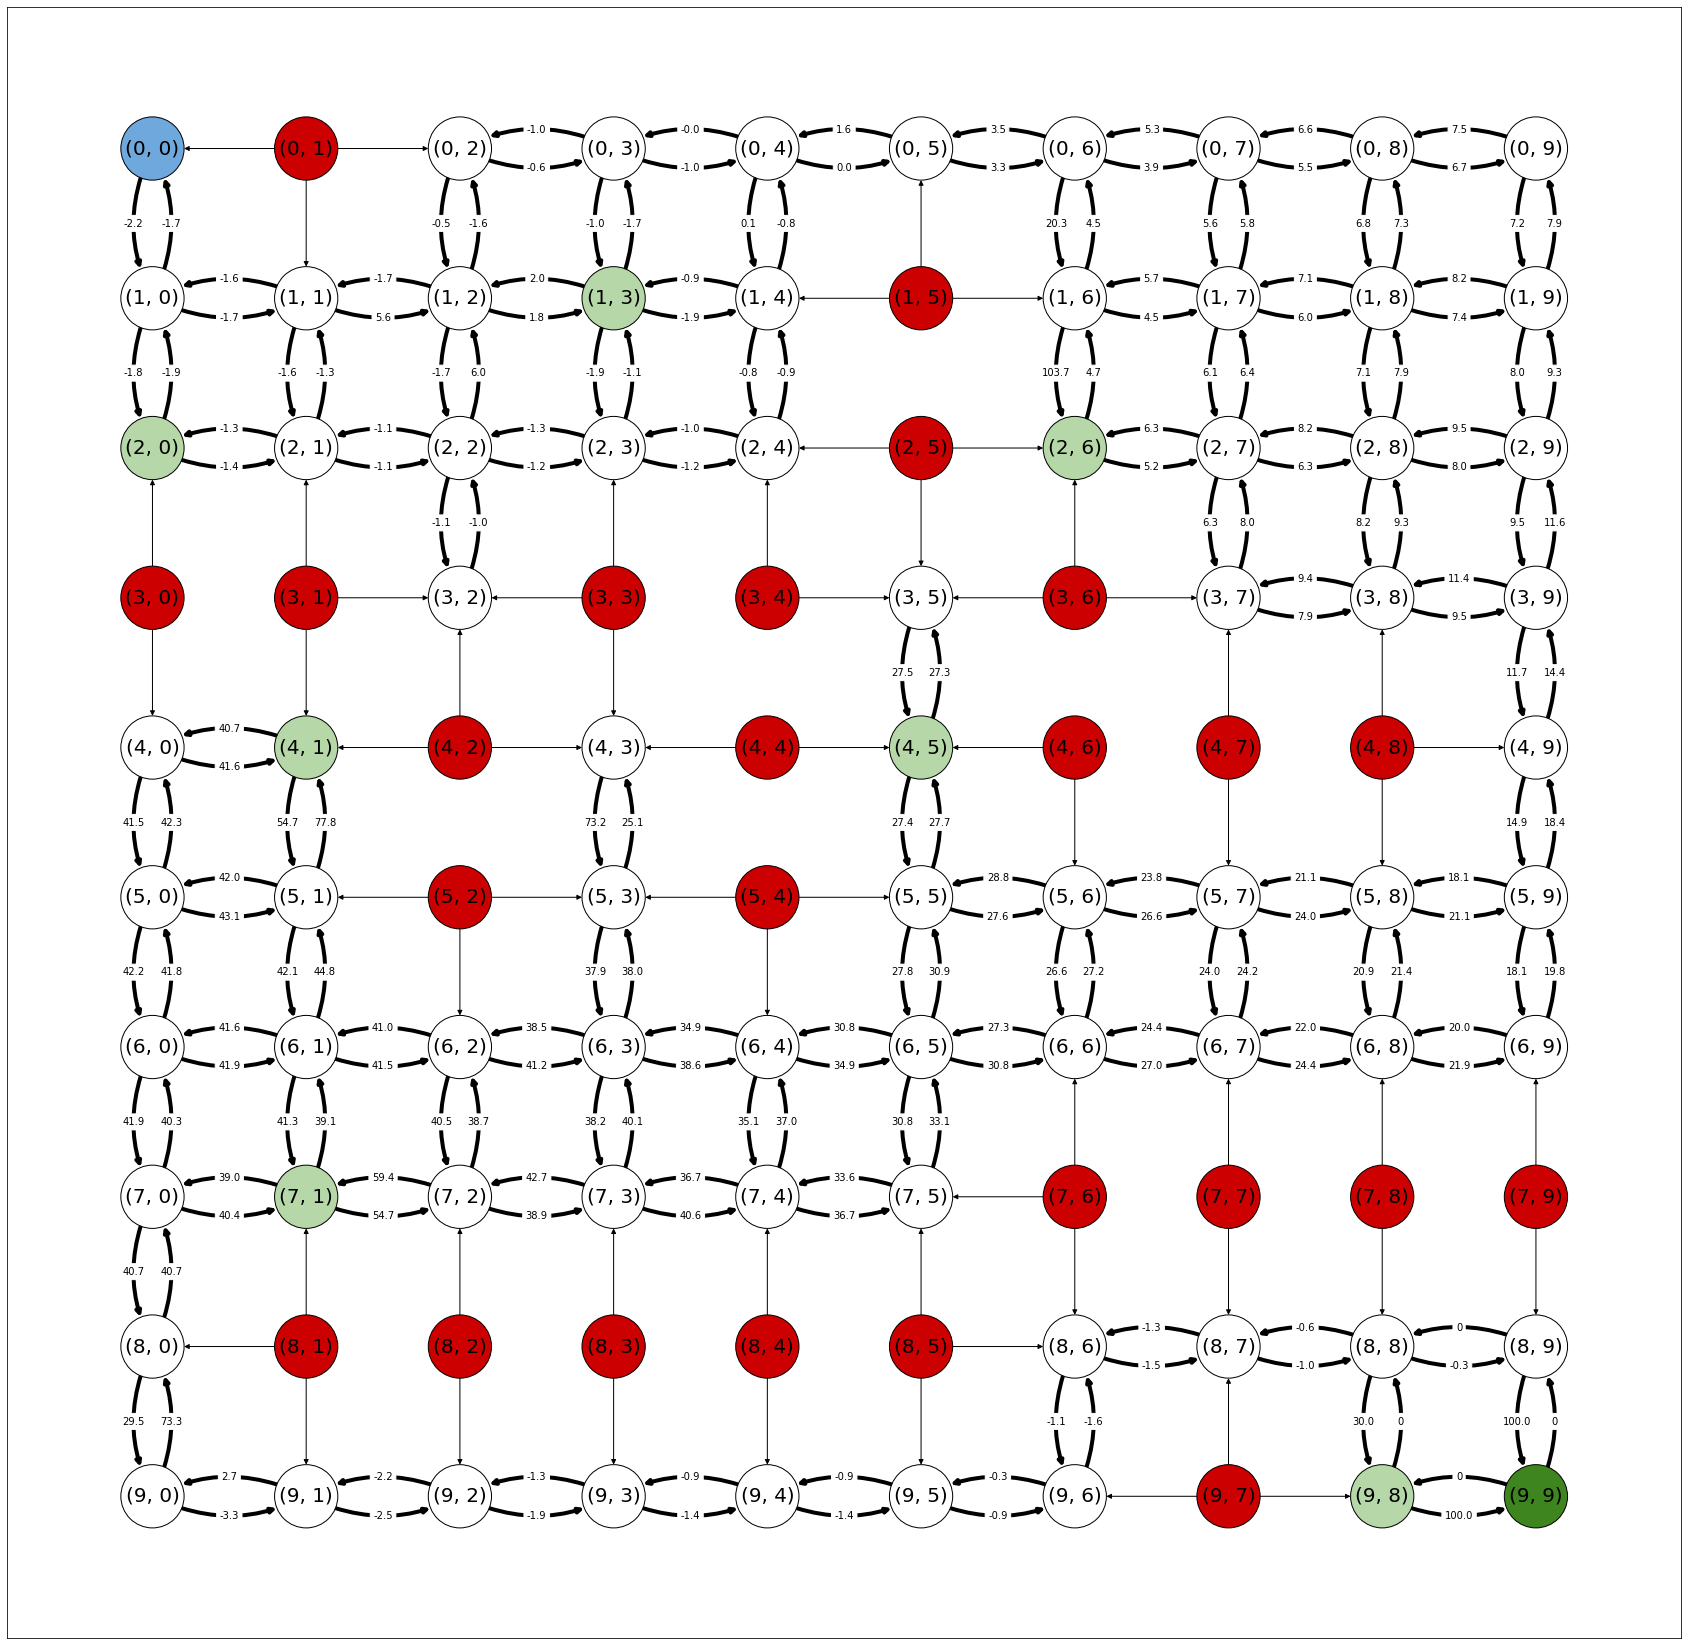

gamma:0.5,alpha:1


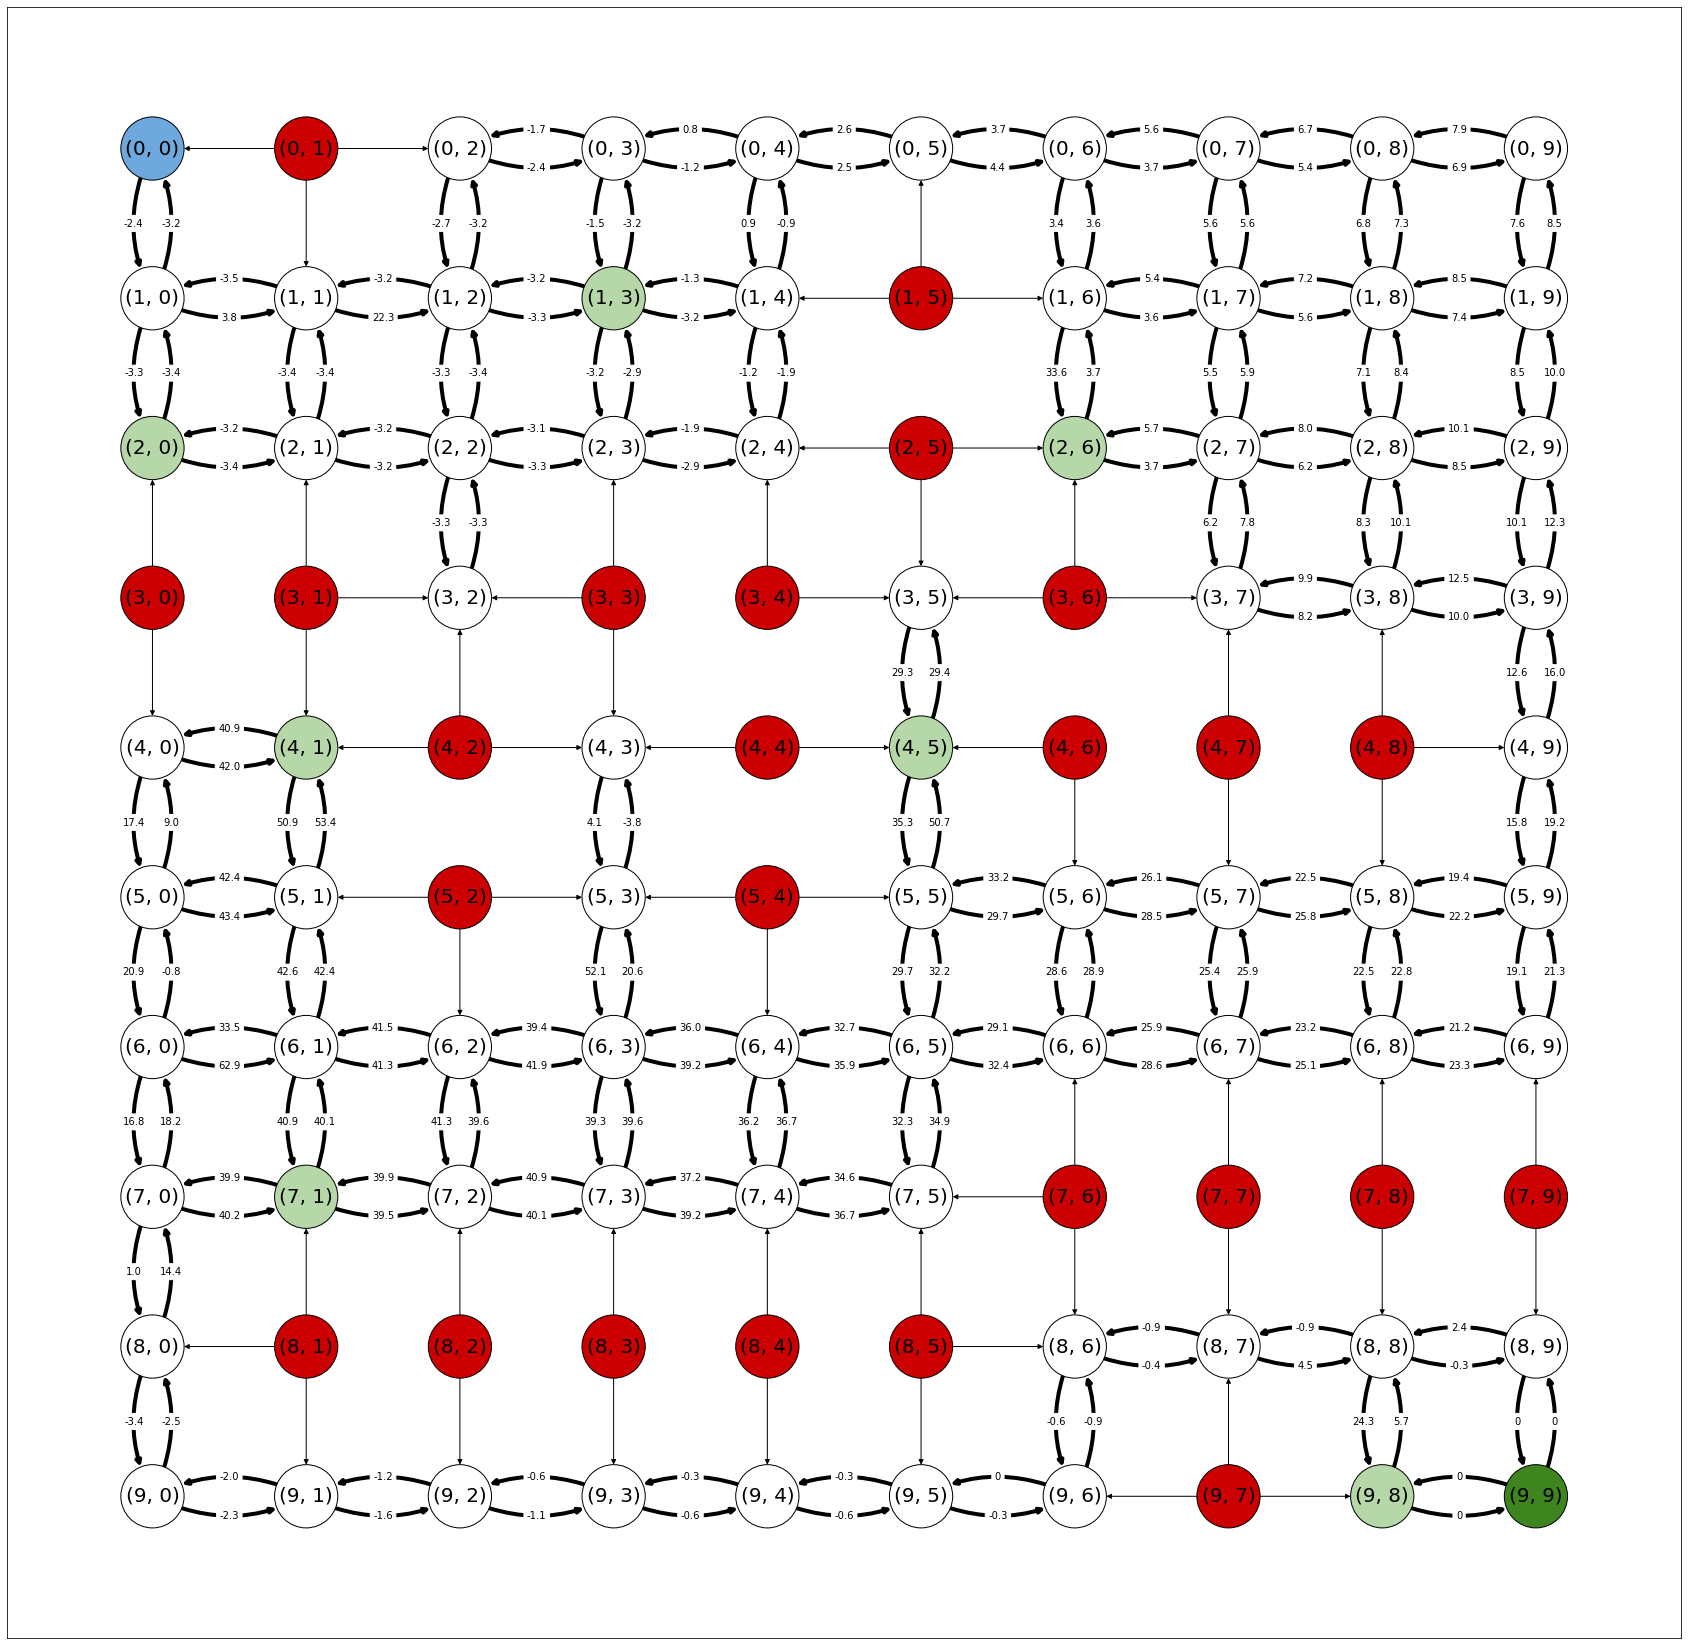

gamma:1,alpha:0.1


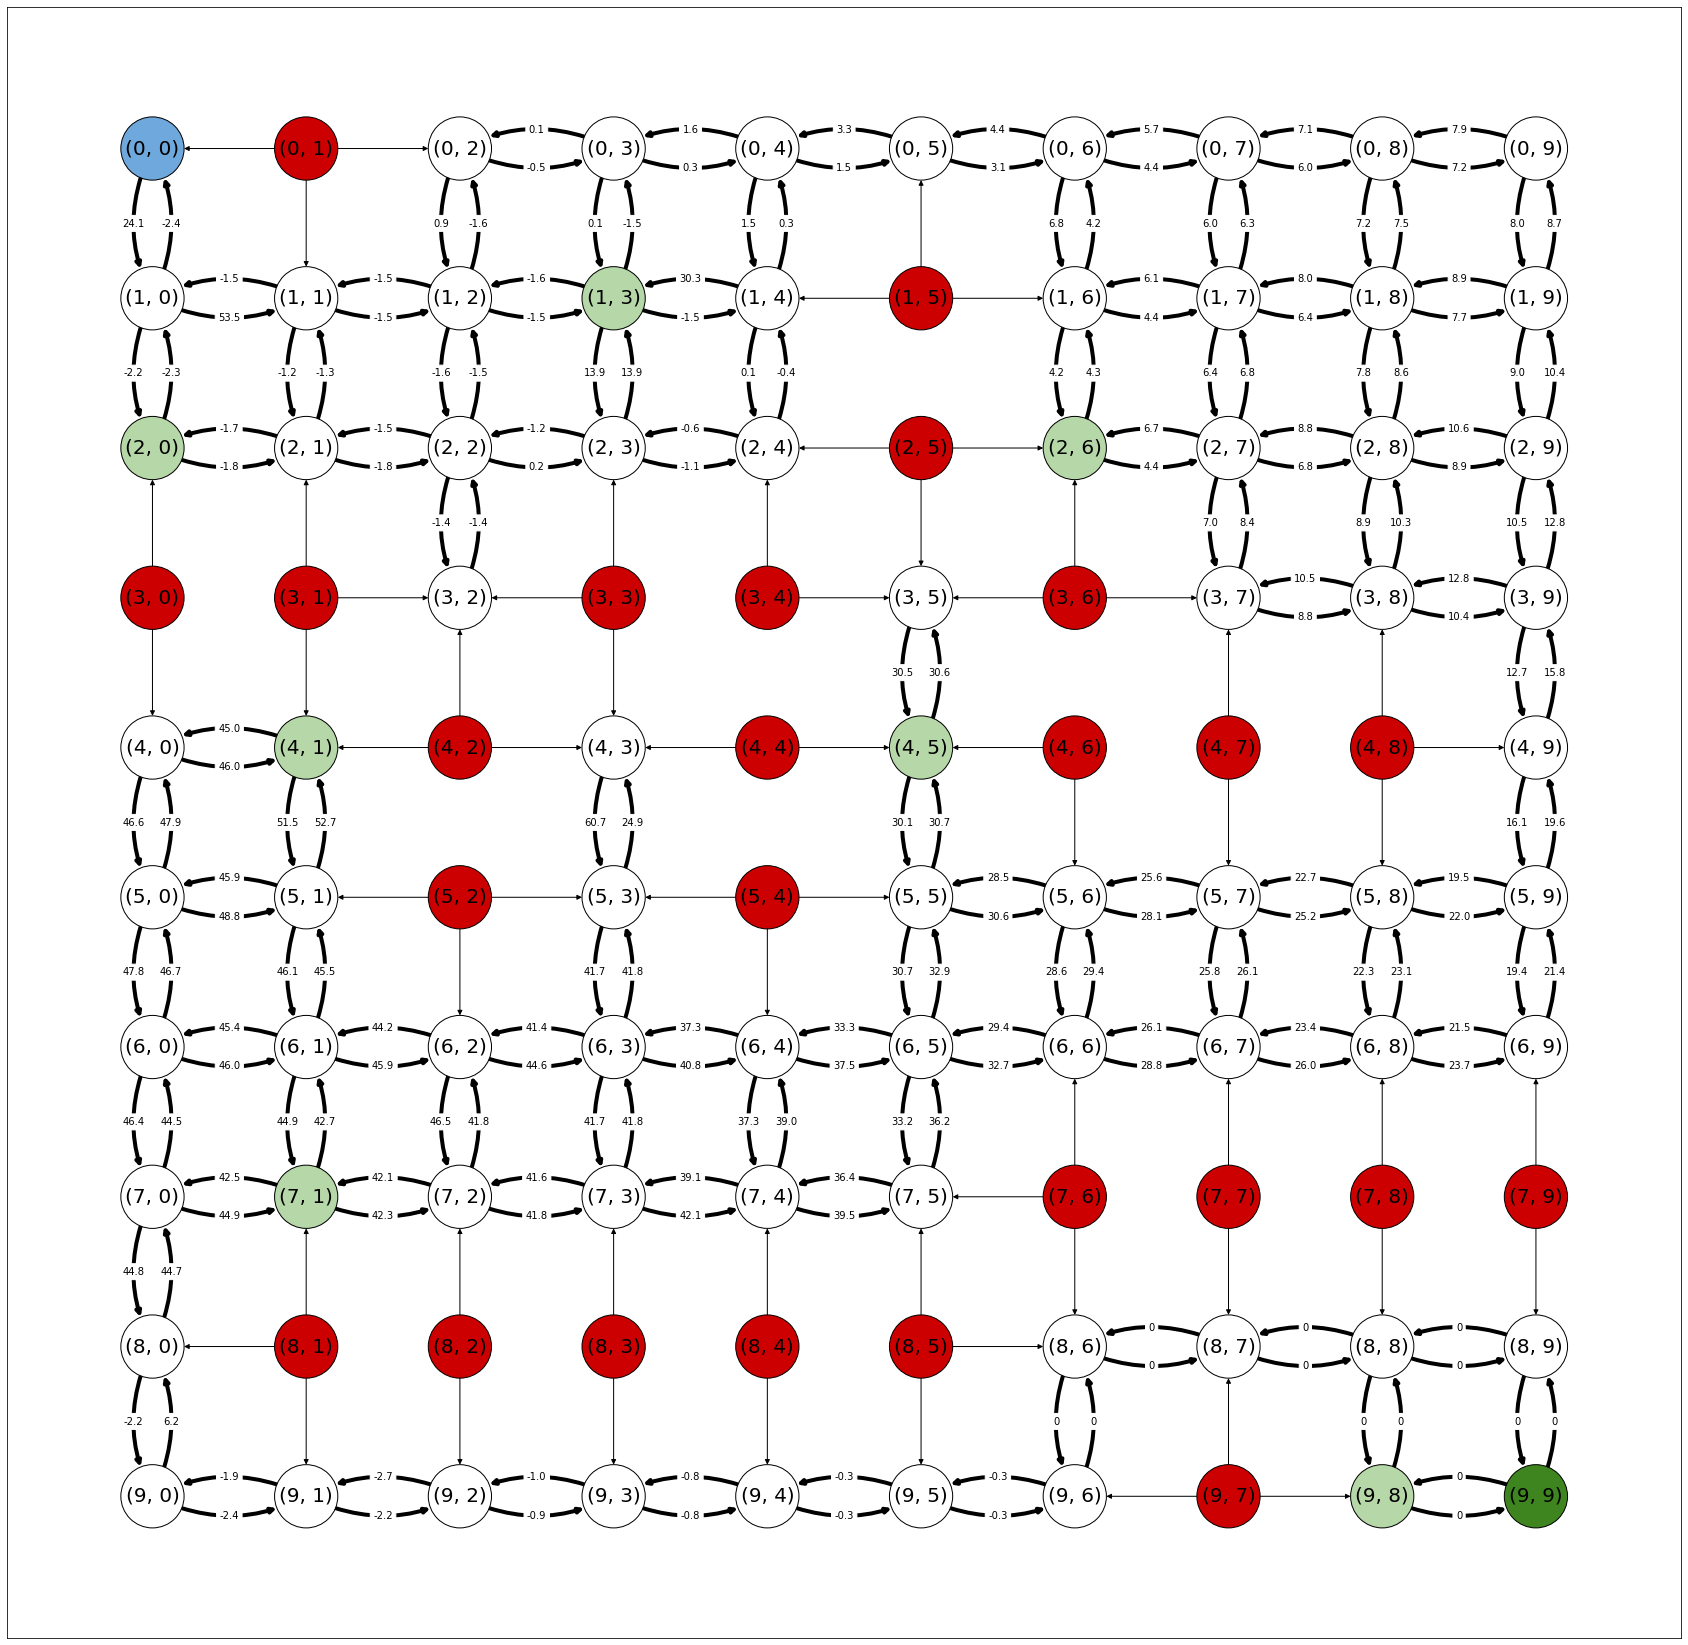

gamma:1,alpha:0.5


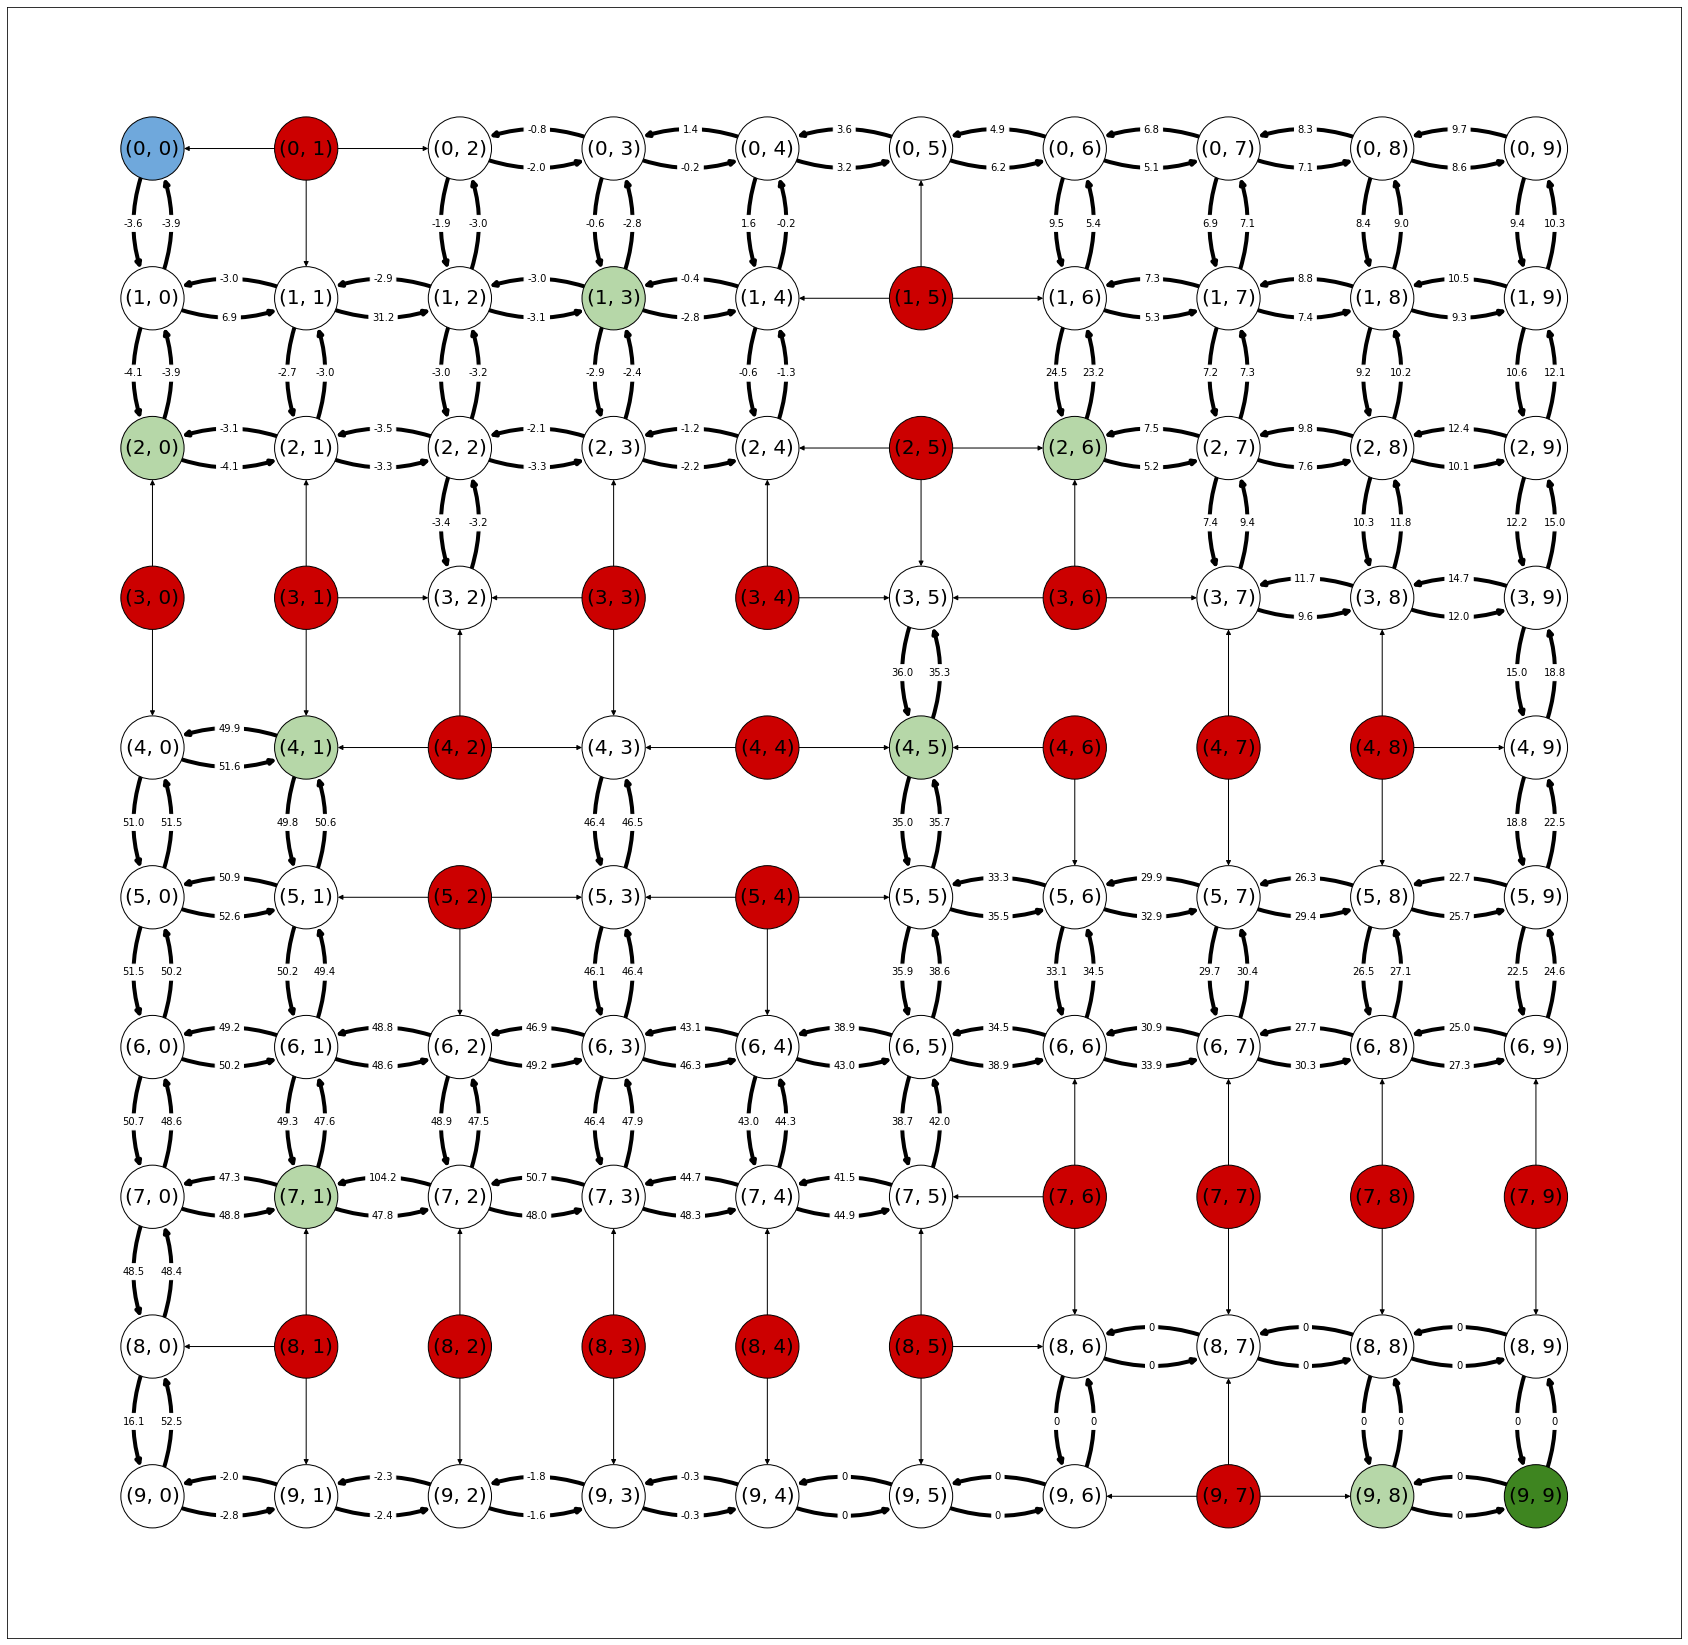

gamma:1,alpha:1


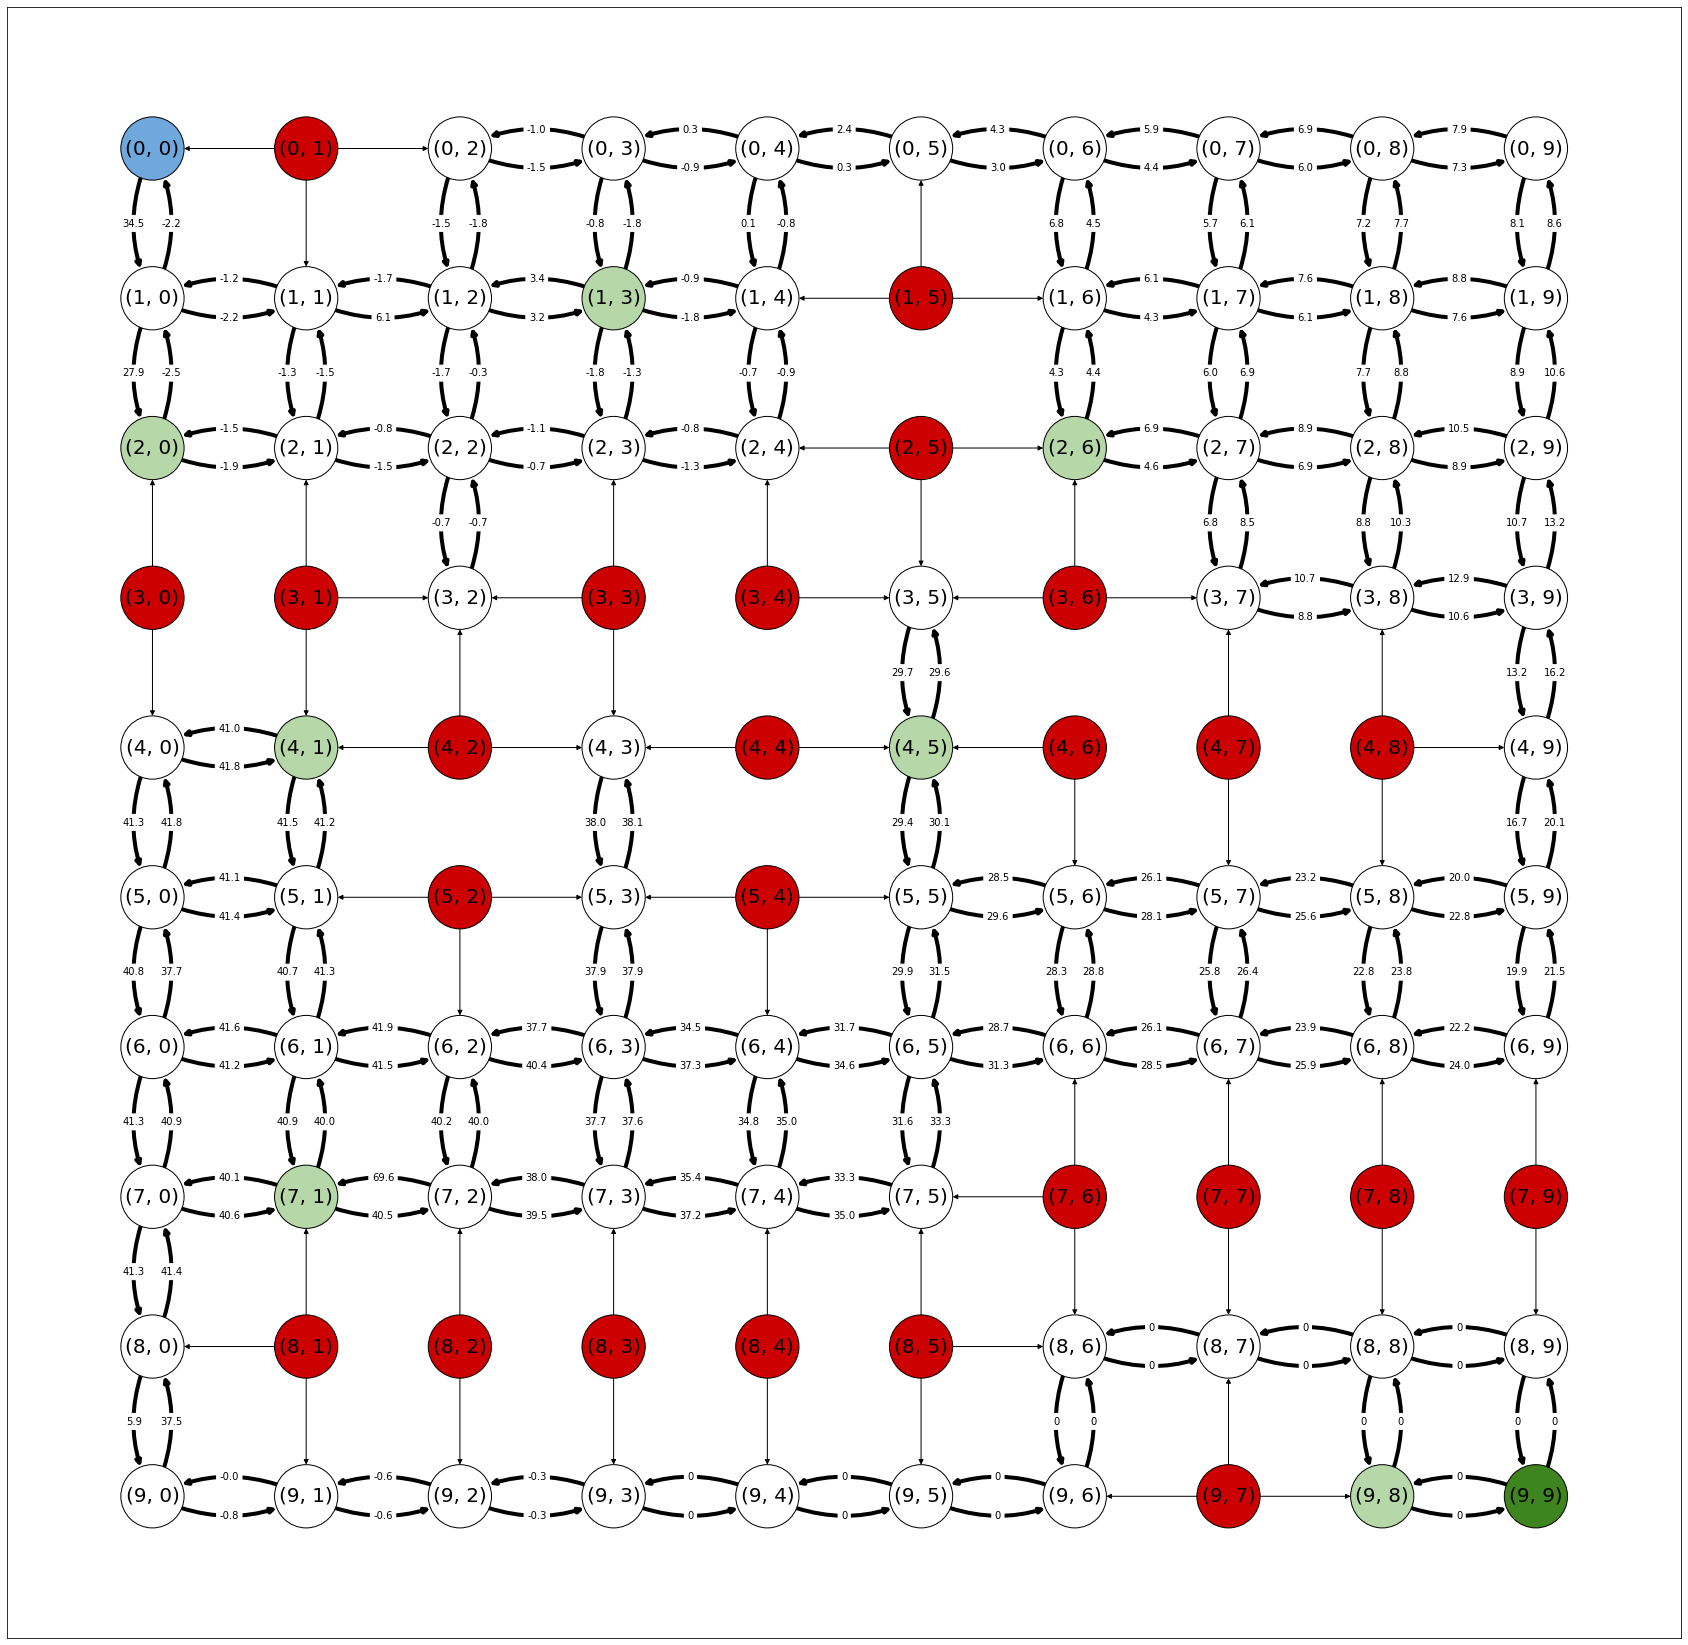

In [356]:
models = []
for gamma in [0.25,0.5,1]:
    for alpha in [0.1,0.5,1]:
        model = Q_learning(alpha=0.1, gamma=0.9, epsilon=1,episode_count=5000)
        Q = model.fit(environment)
        models.append(model)
        print(f'gamma:{gamma},alpha:{alpha}')
        Q.draw()
        plt.show()

In [360]:
model = models[4]
model.get_path(environment)

[((0, 0), 'D'),
 ((1, 0), 'D'),
 ((2, 0), 'U'),
 ((1, 0), 'R'),
 ((1, 1), 'R'),
 ((1, 2), 'R'),
 ((1, 3), 'R'),
 ((1, 4), 'U'),
 ((0, 4), 'R'),
 ((0, 5), 'R'),
 ((0, 6), 'D'),
 ((1, 6), 'D'),
 ((2, 6), 'R'),
 ((2, 7), 'R'),
 ((2, 8), 'D'),
 ((3, 8), 'R'),
 ((3, 9), 'D'),
 ((4, 9), 'D'),
 ((5, 9), 'L'),
 ((5, 8), 'D'),
 ((6, 8), 'L'),
 ((6, 7), 'U'),
 ((5, 7), 'L'),
 ((5, 6), 'L'),
 ((5, 5), 'U'),
 ((4, 5), 'D'),
 ((5, 5), 'D'),
 ((6, 5), 'L'),
 ((6, 4), 'D'),
 ((7, 4), 'L'),
 ((7, 3), 'L'),
 ((7, 2), 'L'),
 ((7, 1), 'L'),
 ((7, 0), 'U'),
 ((6, 0), 'U'),
 ((5, 0), 'R'),
 ((5, 1), 'U'),
 ((4, 1), 'D'),
 ((5, 1), 'L'),
 ((5, 0), 'D'),
 ((6, 0), 'D'),
 ((7, 0), 'D'),
 ((8, 0), 'D'),
 ((9, 0), 'R'),
 ((9, 1), 'R'),
 ((9, 2), 'R'),
 ((9, 3), 'R'),
 ((9, 4), 'R'),
 ((9, 5), 'R'),
 ((9, 6), 'U'),
 ((8, 6), 'R'),
 ((8, 7), 'R'),
 ((8, 8), 'D'),
 ((9, 8), 'R')]